In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import os
#use to process image in real time 
import cv2
import numpy as np
#random number generator to use when shuffling the data
from sklearn.utils import shuffle
#from keras import backend as K

from PIL import Image
from sklearn.decomposition import PCA

#from keras.utils import np_utils

from sklearn.preprocessing import StandardScaler

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

import skimage
from skimage.io import imread
from skimage.transform import resize
import matplotlib.cm as cm

In [3]:
#get full path
PATH = os.getcwd()
# Define data path
print(PATH)

E:\Thesis\Thesis NEw


In [4]:
img_data_list = os.listdir(PATH+'\input')
print(img_data_list)


['000000 (3).jpg', '000000 (4).jpg', '000001.jpg', '000003.jpg', '000008 (1).jpg', '000008.jpg', '000021.jpg', '000023.jpg', '000029.jpg', '000034.jpg', '000050 (1).jpg', '000050.jpg', '000053.jpg', '000055.jpg', '000061.jpg', '000063.jpg', '000064.jpg', '000068.jpg', '000071(1).jpg', '000071.jpg', '000073.jpg', '000079(1).jpg', '000079.jpg', '000082.jpg', '000083.jpg', '000085.jpg', '000087.jpg', '000091.jpg', '000098.jpg', '000099(1).jpg', '000099.jpg', '000102.jpg', '000103.jpg', '000105.jpg', '000107.jpg', '000120.jpg', '000121.jpg', '000122.jpg', '000128.jpg', '000132.jpg', '000134.jpg', '000141(1).jpg', '000141.jpg', '000142(1).jpg', '000142.jpg', '000145(1).jpg', '000145.jpg', '000146.jpg', '000148(1).jpg', '000148.jpg', '000150.jpg', '000153.jpg', '000155.jpg', '000169.jpg', '000182.jpg', '000183.jpg', '000184.jpg', '000192(1).jpg', '000192.jpg', '000204.jpg', '000210.jpg', '000221.jpg', '000222.jpg', '000223.jpg', '000224.jpg', '000244.jpg', '000258.jpg', '03.jpg', 'ID_0000_AG

In [5]:
inputImagePath = "E:/Thesis/Thesis NEw/input/"
for img in img_data_list:
    #print(inputImagePath+img)
    imgRead = cv2.imread(inputImagePath+img)
   
    medianBlur = cv2.medianBlur(imgRead, 5)
    
    cv2.imwrite(os.path.join("E:/Thesis/Thesis NEw/medianBlur/", img),medianBlur)



In [6]:
def motion_process(len, size):
    sx, sy = size
    PSF = np.zeros((sy, sx))
    PSF[int(sy / 2):int(sy /2 + 1), int(sx / 2 - len / 2):int(sx / 2 + len / 2)] = 1
    return PSF / PSF.sum()

In [7]:
def make_blurred(input, PSF, eps):
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF) + eps
    blurred = np.fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(np.fft.fftshift(blurred))
    return blurred

In [8]:
def wiener(input, PSF, eps):
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF) + eps 
    result = np.fft.ifft2(input_fft / PSF_fft) 
    result = np.abs(np.fft.fftshift(result))
    return result

In [9]:
inputBlurredImagepath = "E:/Thesis/Thesis NEw/medianBlur/"
Blurredimg_data_list = os.listdir(inputBlurredImagepath)
for img in Blurredimg_data_list:
    image = Image.open('E:/Thesis/Thesis NEw/medianBlur/'+img).convert('L')
    data = np.asarray(image.getdata()).reshape(image.size)
    PSF = motion_process(30, data.shape)
    blurred = np.abs(make_blurred(data, PSF, 1e-3))
    #blurred += 0.1 * blurred.std() * np.random.standard_normal(blurred.shape)
    weinerBlur = wiener(blurred, PSF, 1e-3)
    cv2.imwrite(os.path.join("E:/Thesis/Thesis NEw/weinerBlur/", img),weinerBlur)
    #blurred += 0.1 * blurred.std() * np.random.standard_normal(blurred.shape)
    #cv2.imwrite(os.path.join("E:/Thesis/Thesis NEw/weinerBlur/", img),blurred)   #okay
    

In [10]:
# Python program to transform an image using 
# threshold. 
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 

inputBlurredImagepath = "E:/Thesis/Thesis NEw/weinerBlur/"
Blurredimg_data_list = os.listdir(inputBlurredImagepath)
for img in Blurredimg_data_list:
    imga = cv2.imread(inputBlurredImagepath+img)
   
    gray = cv2.cvtColor(imga, cv2.COLOR_BGR2GRAY) 
    
    ret, thresh = cv2.threshold(gray, 0, 255, 
                            cv2.THRESH_BINARY_INV +
                            cv2.THRESH_OTSU) 
#cv2.imshow('image', thresh) 
    cv2.imwrite(os.path.join("E:/Thesis/Thesis NEw/thresholding/", img),thresh)
    #cv2.imwrite('C:\\Users\\shamb\\Desktop\\003.jpg',thresh)

In [11]:
import pywt
import pywt.data      #from previious code works fine
BLUR = 21
inputImagePath = "E:/Thesis/Thesis NEw/thresholding/"
for img in img_data_list:
    imgRead = cv2.imread(inputImagePath+img, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(imgRead, 220, 255, cv2.THRESH_BINARY_INV)
 
    kernal = np.ones((5,5), np.uint8)
    erosion = cv2.erode(mask, kernal, iterations=1)
    dilation = cv2.dilate(erosion, kernal, iterations=1)
    
    
    opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernal)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernal)
    mg = cv2.morphologyEx(erosion, cv2.MORPH_GRADIENT, kernal)
    th = cv2.morphologyEx(mg, cv2.MORPH_TOPHAT, kernal)
    
    coeffs2 = pywt.dwt2(dilation, 'db1')
    LL, (LH, HL, HH) = coeffs2
    titles = ['Approximation', ' Horizontal detail',
             'Vertical detail', 'Diagonal detail']
    coeffs2 = pywt.dwt2(LL, 'db1')
    LL, (LH, HL, HH) = coeffs2
    
     
    cv2.imwrite(os.path.join("E:/Thesis/Thesis NEw/erosion/", img),LL)
    print("shape of image : ",LL.shape)
    
    

shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image :  (128, 128)
shape of image

In [12]:
import os, random                   
import numpy as np
import pandas as pd
import PIL
import keras
import itertools
from PIL import Image




from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage import feature, data, io, measure
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [14]:
path_to_train = 'E:\\Thesis\\Thesis NEw\\train'
path_to_test = 'E:\\Thesis\\Thesis NEw\\test'
path_to_val = 'E:\\Thesis\\Thesis NEw\\val'

In [15]:
train_cat = [x for x in os.listdir(path_to_train) if x[0] is not '.']
test_cat = [x for x in os.listdir(path_to_test) if x[0] is not '.']
val_cat = [x for x in os.listdir(path_to_val) if x[0] is not '.']

In [16]:
def files_per_directory(base_dir, categories):
    files_per_dir = []

    for category in categories:
        files = os.listdir(os.path.join(base_dir, category))
        files_per_dir.append(len(files))

    return files_per_dir

In [17]:
train_dir = files_per_directory(path_to_train, train_cat)
test_dir = files_per_directory(path_to_test, test_cat)
val_dir = files_per_directory(path_to_val, val_cat)

In [18]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255)

valid_datagen = ImageDataGenerator(
        rescale=1./255)

In [19]:
batch_size = 32
image_size = 128
    
train_generator = train_datagen.flow_from_directory(
        path_to_train,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        path_to_test,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='sparse')


validation_generator = valid_datagen.flow_from_directory(
        path_to_val,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='sparse')

print("Shape of training images {}".format(train_generator.image_shape))
print("Shape of test images {}".format(test_generator.image_shape))
print("Shape of validation images {}".format(validation_generator.image_shape))
#classes=['Normal','Pneumonia'],

Found 86 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Shape of training images (128, 128, 1)
Shape of test images (128, 128, 1)
Shape of validation images (128, 128, 1)


In [52]:
batch_size = 32
IMG_SHAPE = 128
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))




model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



epochs = 80

history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(train_generator.n / float(batch_size))),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=int(np.ceil(test_generator.n / float(batch_size)))
)


Epoch 1/80
3/3 [==============================] - 1s 459ms/step - loss: 0.8584 - accuracy: 0.6279 - val_loss: 0.7390 - val_accuracy: 0.4231
Epoch 2/80
3/3 [==============================] - 1s 368ms/step - loss: 0.6921 - accuracy: 0.5465 - val_loss: 0.4766 - val_accuracy: 0.6923
Epoch 3/80
3/3 [==============================] - 1s 373ms/step - loss: 0.6098 - accuracy: 0.6744 - val_loss: 0.7347 - val_accuracy: 0.6923
Epoch 4/80
3/3 [==============================] - 1s 385ms/step - loss: 0.5967 - accuracy: 0.6512 - val_loss: 0.7352 - val_accuracy: 0.6923
Epoch 5/80
3/3 [==============================] - 1s 370ms/step - loss: 0.5856 - accuracy: 0.6628 - val_loss: 0.5033 - val_accuracy: 0.6923
Epoch 6/80
3/3 [==============================] - 1s 374ms/step - loss: 0.5686 - accuracy: 0.6512 - val_loss: 0.6246 - val_accuracy: 0.6923
Epoch 7/80
3/3 [==============================] - 1s 368ms/step - loss: 0.5529 - accuracy: 0.6744 - val_loss: 0.3699 - val_accuracy: 0.7308
Epoch 8/80
3/3 [====

In [21]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [54]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (128, 128, 1))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('C:\\Users\\shamb\\Desktop\\004.jpg')
model.predict(image)

array([[0.89069694, 0.10930305]], dtype=float32)

In [55]:
img = 'C:\\Users\\shamb\\Desktop\\004.jpg'

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def prepare_image(image, target):
    # if the image mode is not RGB, convert it
    image = Image.open(img)
    
    if image.mode == "RGB":
        image = image.convert("L")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    image = image.reshape(-1,128,128,1) / 255.

    # return the processed image
    return image

In [57]:
def model_predict(img_path, model):
    data = {'success': False}
    image = Image.open(img)
    image = prepare_image(image, target=(128,128))
    prediction = model.predict(image)
    class_predicted = np.argmax(prediction)
    data['prediction'] = []
    data['prediction'].append(class_predicted)
    data['success'] = True
    return str(data)


In [58]:
validation_generator.class_indices

{'Cancer': 0, 'Normal': 1}

In [59]:
model_predict(img, model)

"{'success': True, 'prediction': [0]}"

In [80]:
from tensorflow.keras.callbacks  import TensorBoard, ReduceLROnPlateau
optimizer = 'adam'
epoch = 15
loss = 'binary_crossentropy'

NAME = 'X_ray_classifier-{}-{}-{}'.format(optimizer,epoch,loss)

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

es = EarlyStopping(patience=5)

#checkpoint = ModelCheckpoint('best_model.h5',save_best_only=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

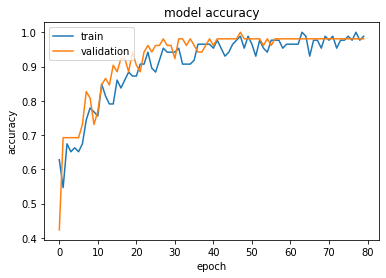

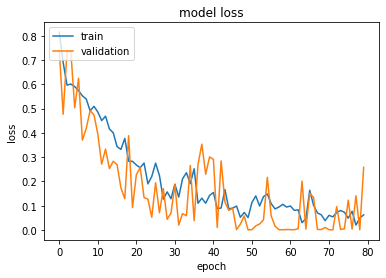

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [93]:
score = model.evaluate_generator(test_generator)

In [94]:
score

[0.2598417103290558, 0.8461538553237915]

In [96]:
import time
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1586148898.h5
